In [1]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import symbols, nroots, Poly, Matrix, simplify, shape
import control as ct

plt.rcParams.update({
    "text.usetex": True,
    "font.family" : "Computer Modern Serif", 
})

____
# GENERAL SET UP
____
The theoretical modeling of the combined pendulum-cart system is done in the accompanying pdf. Exact expressions for the PID-controlled closed loop transfer function and the output responses to impulse and finite-length step disturbances are derived there. The pdf also reviews the formalism for Linear Quadratic Regulator (LQR) and Linear Quadratic Gaussian (LQG) problems.

This notebook is separated into 3 general sections:
 - PID control
 - Optimal control (LQR)
 - Optimal filter and control (LQG)

The 1st section focuses on tuning the PID controller using a trial-and-error approach. We compare the exact expressions for the disturbance responses to results obtained using the **mpmath** package to do numerical inverse Laplace transforms.

The 2nd section focuses on optimal control and solving the LQR problem using the **control** package. Simulation of the system to an impulse disturbance is done using built-in functions.

The 3rd section focuses on optimal filtering/control and solving the LQG problem using a combination of by-hand calculations for simplification and the **control** package. Simulation of impulse response is then done with the built-in functions.

Many calculations in the notebook are done using the **sympy** package (e.g. finding roots of polynomials and matrix multiplication/inversion).

In [2]:
#Define the Laplace variable s
s = symbols('s')

#A ubiquitous physical constant dependent on the system parameters, derived in the pdf
def mu(m=1., M=2., l=0.5, I=0.08333):
    return (m+M)*(I + m*l**2) - (m*l)**2

____
# PID CONTROL
____

## DEFINITIONS

The cart and pendulum have different closed loop transfer functions (since we are not directly controlling the cart in the feedback loop). Nevertheless, they share the same denominator function.

In [3]:
#Denominator of the closed loop transfer function, to be used with nroots() to find the poles of the transfer function
def denom_symb(Ki, Kp, Kd, s, m=1., M=2., I=0.08333, l=0.5, b=0.1):
    g = 9.8
    return s**3 + ((b*m*(l**2) + Kd*m*l + I*b)*s**2)/mu() + (-g*l*m*M - (m**2)*g*l  + Kp*m*l)*s/mu() + (Ki*m*l - b*m*g*l)/mu()

#Denominator of the closed loop transfer function, to be used in inverse Laplace transforms
def denom(Ki, Kp, Kd, x, m=1., M=2., I=0.08333, l=0.5, b=0.1):
    g = 9.8
    return mp.power(x,3) + ((b*m*(l**2) + Kd*m*l + I*b)*mp.power(x,2))/mu() + (-g*l*m*M - (m**2)*g*l  + Kp*m*l)*mp.power(x,1)/mu() + (Ki*m*l - b*m*g*l)/mu()

#Pedulum closed loop transfer function, to be used in inverse Laplace transforms
def Gp(x, Ki, Kp, Kd, m=1., l=0.5):
    return (m * l * x/ mu())/denom(Ki, Kp, Kd, x)

#Cart closed loop transfer function, to be used in inverse Laplace transforms
def Gc(x, Ki, Kp, Kd, m=1., l=0.5, I=0.08333):
    g = 9.8
    numerator = (I + m * l**2)*(x**2) - m*g*l
    return numerator/(x*denom(Ki, Kp, Kd, x))

In [4]:
#Analytical inverse Laplace transform of Gp
def pend_impulse_response(t, Ki, Kp, Kd, m = 1., l=0.5):
    coeff = m*l/mu()
    roots = nroots(denom_symb(Ki, Kp, Kd, s))
    term1 = -roots[0] * mp.exp(roots[0]*t)/((roots[1]-roots[0])*(roots[0]-roots[2]))
    term2 = roots[1] * mp.exp(roots[1]*t)/((roots[1]-roots[0])*(roots[1]-roots[2]))
    term3 = -roots[2] * mp.exp(roots[2]*t)/((roots[0]-roots[2])*(roots[2]-roots[1]))
    out = mp.mpc(complex(coeff * (term1 + term2 + term3)))
    return out.real

In [5]:
def cart_output_part(t, a, b, c, p1, p2):
    denominator = a*(a-b)*(a-c)
    coefficient = (a**2)*p1 + p2
    return coefficient * mp.exp(a*t)/denominator

#Analytical inverse Laplace transform of Gc
def cart_impulse_response(t, Ki, Kp, Kd, m=1., l=0.5, I=0.08333):
    g=9.8
    p1 = I + m*(l**2)
    p2 = -m*g*l
    roots = nroots(denom_symb(Ki, Kp, Kd, s))
    out = mp.mpc(complex(cart_output_part(t, roots[0], roots[1], roots[2], p1, p2)
    + cart_output_part(t, roots[1], roots[0], roots[2], p1, p2)
    + cart_output_part(t, roots[2], roots[1], roots[0], p1, p2)
    - p2/(roots[0]*roots[1]*roots[2])))
    return out.real

In [6]:
#Numerical inverse Laplace transform of Gp
def pend_num_impulse_response(t, Ki, Kp, Kd):
    fn = lambda x: Gp(x, Ki, Kp, Kd)
    return mp.invertlaplace(fn, t, method='dehoog')

#Numerical inverse Laplace transform of Gc
def cart_num_impulse_response(t, Ki, Kp, Kd):
    fn = lambda x: Gc(x, Ki, Kp, Kd)
    return mp.invertlaplace(fn, t, method='dehoog')

In [7]:
#Heavisde Theta (step) function
def Heaviside(t, t0):
    if t-t0 >= 0.:
        return mp.mpf(1.)
    else:
        return mp.mpf(0.)

def cart_step_output_part(t, t_delay, z1, z2, z3):
    return mp.exp(z1 * (t-t_delay))/((z1-z2)*(z1-z3))

#Analytical inverse Laplace result giving pendulum's finite-length step response
def pend_step_response(t, Ki, Kp, Kd, m=1., l=0.5, t_start = 0., t_end = 0.5):
    coeff = m*l/mu()
    roots = nroots(denom_symb(Ki, Kp, Kd, s))
    term1 = (cart_step_output_part(t, t_start, roots[0], roots[1], roots[2]) + cart_step_output_part(t, t_start, roots[1], roots[0], roots[2]) + 
            cart_step_output_part(t, t_start, roots[2], roots[1], roots[0])) * Heaviside(t, t_start)
    term2 = (cart_step_output_part(t, t_end, roots[0], roots[1], roots[2]) + cart_step_output_part(t, t_end, roots[1], roots[0], roots[2]) + 
             cart_step_output_part(t, t_end, roots[2], roots[1], roots[0])) * Heaviside(t, t_end)
    out = mp.mpc(complex(coeff*(term1-term2)))
    return out.real

In [8]:
#Expression for pendulum's response to finite-length step disturbance in Laplace space, to be used in numerical inverse Laplace transform
def Y_theta_Laplace_step(x, Ki, Kp, Kd, m=1., l=0.5, t_start=0., t_end=0.5):
    return (m * l/ mu())*(mp.exp(-t_start*x) - mp.exp(-t_end*x))/denom(Ki, Kp, Kd, x)

#Expression for cart's response to finite-length step disturbance in Laplace space, to be used in numerical inverse Laplace transform
def Y_x_Laplace_step(x, Ki, Kp, Kd, m=1., l=0.5, I = 0.08333, t_start=0., t_end=0.5):
    return Gc(x, Ki, Kp, Kd) * (mp.exp(-t_start*x) - mp.exp(-t_end*x))/x

In [9]:
def pend_num_step_response(t, Ki, Kp, Kd):
    fn = lambda x: Y_theta_Laplace_step(x, Ki, Kp, Kd)
    return mp.invertlaplace(fn, t, method='dehoog')

def cart_num_step_response(t, Ki, Kp, Kd):
    fn = lambda x: Y_x_Laplace_step(x, Ki, Kp, Kd)
    return mp.invertlaplace(fn, t, method='dehoog')

In [10]:
#Discretized time interval for simulation, begins just after t = 0 to avoid numerical issues in inverse Laplace transforms
T = np.arange(0.00001, 3.,0.005)

## IMPULSE RESPONSE

In [11]:
def impulse_response_plot(time, Ki, Kp, Kd, subsystem):
    
    if subsystem=='pendulum':
        Y1 = np.zeros_like(time)
        for i in range(len(time)):
            Y1[i] = pend_impulse_response(time[i], Ki, Kp, Kd)
            
        with mp.workdps(20):    
            Y_num = np.zeros_like(time)
            for i in range(len(time)):
                Y_num[i] = pend_num_impulse_response(time[i], Ki, Kp, Kd)
    
    elif subsystem=='cart':
        Y1 = np.zeros_like(time)
        for i in range(len(time)):
            Y1[i] = cart_impulse_response(time[i], Ki, Kp, Kd)
            
        with mp.workdps(20):    
            Y_num = np.zeros_like(time)
            for i in range(len(time)):
                Y_num[i] = cart_num_impulse_response(time[i], Ki, Kp, Kd)
    
    else:
        print('Choose "pendulum" or "cart"')
        return
    
    fig1 = plt.figure(figsize=(8,5))
    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

    ax1.plot(time, Y_num, '.', label='numeric')
    ax1.plot(time, Y1, label='exact')

    ax1.set_xlabel('Time (s)')
    
    if subsystem=='pendulum':
        ax1.set_ylabel('$\\theta$ (rad)')
    elif subsystem=='cart':
        ax1.set_ylabel('$x$ (m)')

    ax1.set_title('Numeric vs. Exact (impulse disturbance) \n' + f'$K_p = ${Kp}, $K_i = ${Ki}, $K_d = ${Kd}')
    ax1.legend()

### TRIAL AND ERROR RESULTS

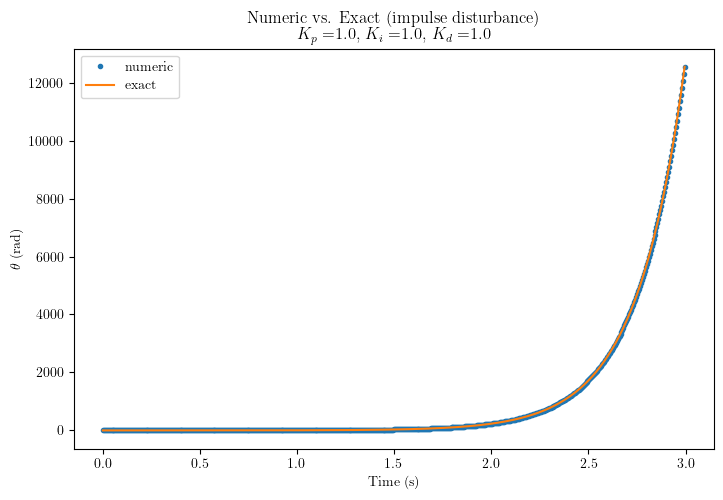

In [12]:
impulse_response_plot(T, Ki=1., Kp=1., Kd=1., subsystem='pendulum')

This is clearly still unstable and so the gains will need to be increased.

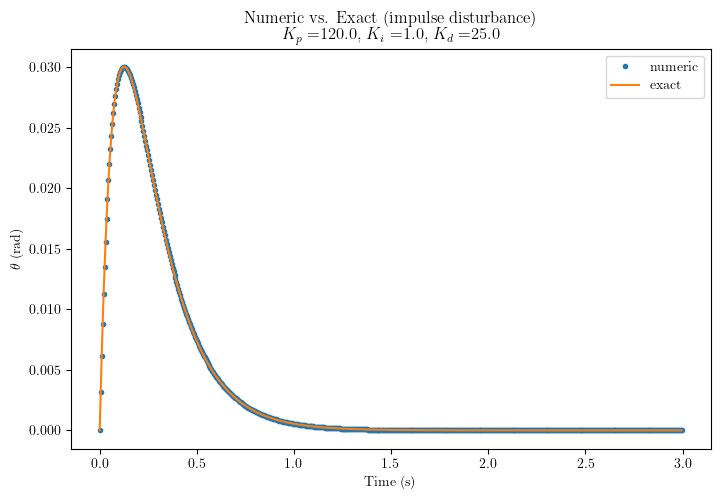

In [13]:
impulse_response_plot(T, Ki=1., Kp=120., Kd=25., subsystem='pendulum')

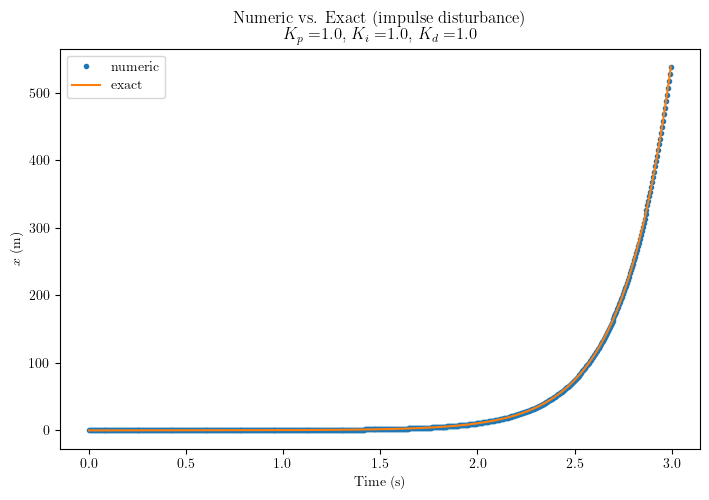

In [14]:
impulse_response_plot(T, Ki=1., Kp=1., Kd=1., subsystem='cart')

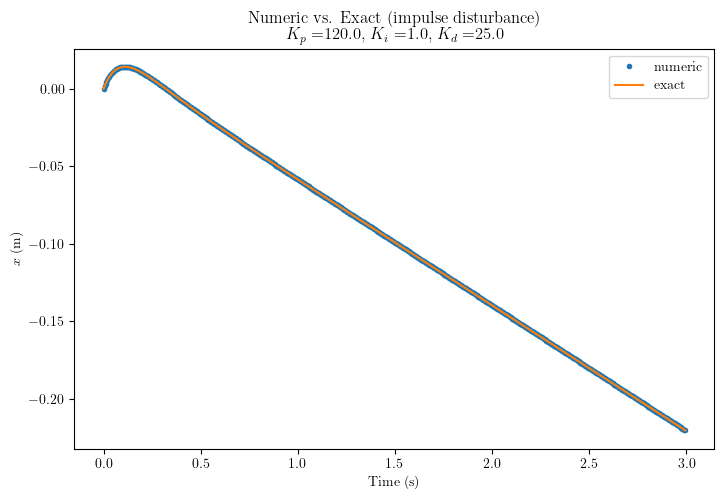

In [15]:
impulse_response_plot(T, Ki=1., Kp=120., Kd=25., subsystem='cart')

Evidently we chose gains that controlled the pendulum's angular position, but at the cost of the cart moving with a constant speed to keep the pendulum stable. This is physically impractical and undesirable.

### FREQUENCY ANALYSIS RESULTS

By looking at the Nyquist and Bode plots (see the accompanying pdf) of the system we can choose different (hopefully better) gain values and see what happens.

In [16]:
#It turns out the new gains yield a slower (but still good) settling time, so we define an extended time interval
T_extended = np.arange(0.00001,5.,0.005)

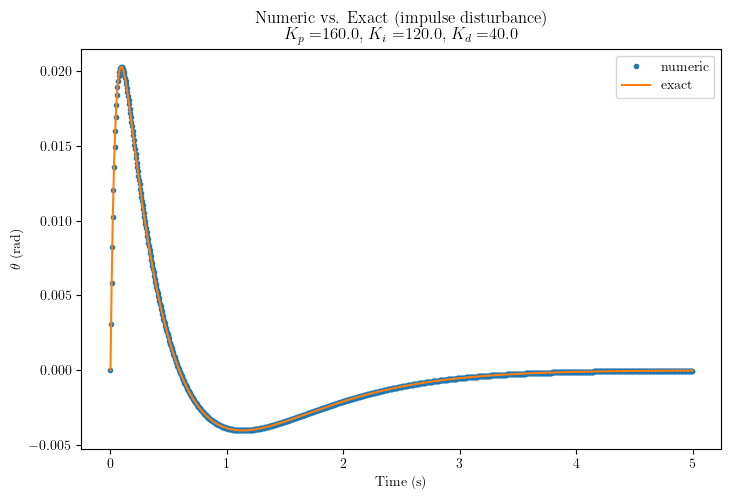

In [17]:
impulse_response_plot(T_extended, Ki=120., Kp=160., Kd=40., subsystem='pendulum')

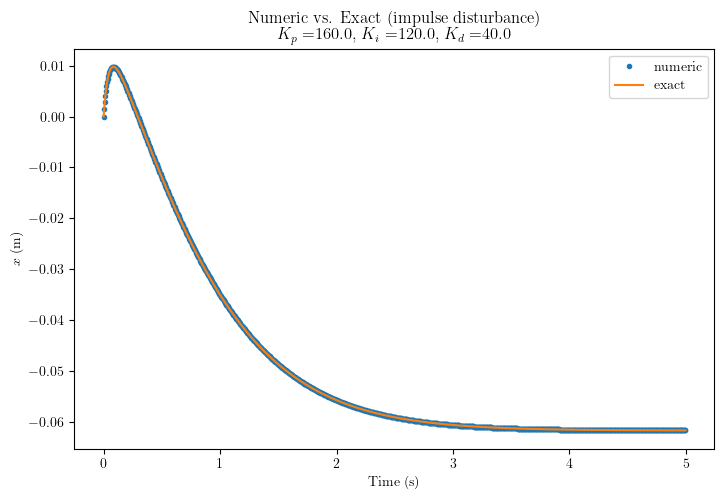

In [18]:
impulse_response_plot(T_extended, Ki=120., Kp=160., Kd=40., subsystem='cart')

We have managed to control the positions of the cart and pendulum despite only designing the feedback loop to control the pendulum!

## STEP RESPONSE

In [19]:
def step_response_plot(time, Ki, Kp, Kd):
    
    Y1 = np.zeros_like(time)
    for i in range(len(time)):
        Y1[i] = pend_step_response(time[i], Ki, Kp, Kd)
        
    with mp.workdps(20):    
        Y_num = np.zeros_like(time)
        for i in range(len(time)):
            Y_num[i] = pend_num_step_response(time[i], Ki, Kp, Kd)
    
    
    fig1 = plt.figure(figsize=(8,5))
    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

    ax1.plot(time, Y_num, '.', label='numeric')
    ax1.plot(time, Y1, label='exact')

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('$\\theta$ (rad)')

    ax1.set_title('Numeric vs. Exact (finite-length step disturbance) \n' + f'$K_p = ${Kp}, $K_i = ${Ki}, $K_d = ${Kd}')
    ax1.legend()

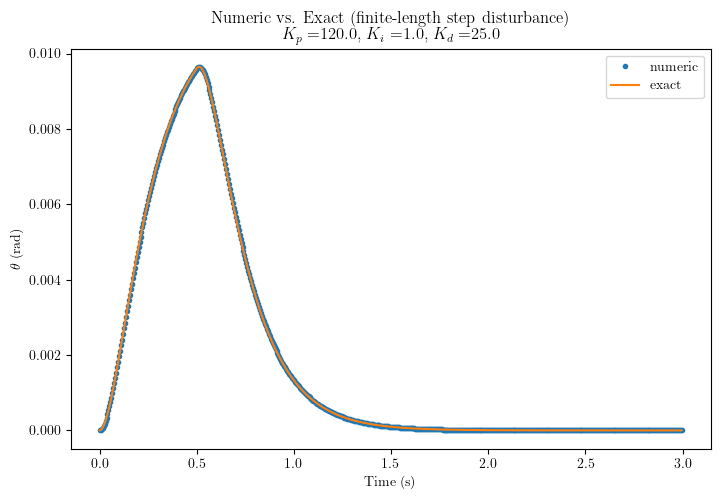

In [20]:
#With the trial and error gains
step_response_plot(T, Ki=1., Kp=120., Kd=25.)

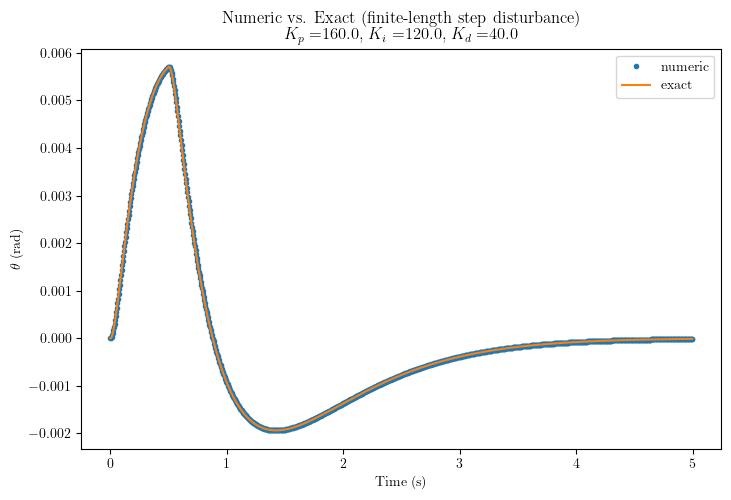

In [21]:
#with the heuristic gains
step_response_plot(T_extended, Ki=120., Kp=160., Kd=40.)

____
# OPTIMAL CONTROL: LQR
____

## DEFINITIONS

Optimal control is typically dealt with in the state space (time domain) formalism, determined by 4 matrices
 - $A$: system dynamics
 - $B$: control/input
 - $C$: output/measurement
 - $D$: throughput
 
In this project we'll set $D = 0$.

In [22]:
#A
def dynamics(m=1., M=2., I=0.08333, l=0.5, b=0.1):
    g = 9.8
    return np.array(
        [
            [0,1,0,0],
            [0, -b*(I + m*l**2)/mu(), ((m*l)**2)*g/mu(), 0],
            [0, 0, 0, 1],
            [0, -b*m*l/mu(), (m+M)*m*g*l/mu(), 0]
        ]
    )

#B    
def input_B(m=1., I=0.08333, l=0.5, b=0.1):
    return np.array(
        [
            [0],
            [(I+m*l**2)/mu()],
            [0],
            [m*l/mu()]
        ]
    )

#C    
def output_C():
    return np.array(
        [
            [1.,0,0,0],
            [0,0,1.,0]
        ]
    )

In [23]:
sys = ct.ss(dynamics(), input_B(), output_C(), 0, outputs=['x', 'theta'], name="inverted pundulum on cart")

## LQR AND IMPULSE RESPONSE

In [24]:
def LQR(system, Q1: float, Q2: float, R: float, labels: list[str]):
    '''
    Designed to take in an LTI system with 4 state variables and one input. Assume the system has no throughput (D = 0).
    Inputs:
     * system: control.ss object
     * Q1, Q2: cost function coefficients for the state deviation penalty
     * R: cost function coefficient for control effort
    '''
    Q = np.array(
        [
            [Q1, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, Q2, 0],
            [0, 0, 0, 0]
        ]
    )
    
    #This built in function in the control package will solve the optimization problem for you
    K, _, _ = ct.lqr(system, Q, R)
    A = system.A
    B = system.B
    C = system.C
    D = 0
    system_ctrl = ct.ss(A - B@K, B, C, D, outputs=labels)
    
    return system_ctrl

In [25]:
def LQR_plots(time, system, Q1: float, Q2: float, R: float, labels: list[str]):
    system_ctrl = LQR(system, Q1, Q2, R, labels)
    
    fig_LQR, (ax_LQR1, ax_LQR2) = plt.subplots(nrows=2, ncols=1, figsize=(8,5))

    #These built in functions calculate and plot the system's response to an impulse disturbance
    ct.time_response_plot(ct.impulse_response(system_ctrl,time), ax=[ax_LQR1, ax_LQR2], title='LQR Impulse Responses')

    ax_LQR1.set_ylabel('$x$ (m)')
    ax_LQR2.set_ylabel('$\\theta$ (rad)')
    ax_LQR2.set_xlabel('Time (s)')

    ax_LQR1.set_title('Cart')
    ax_LQR2.set_title('Pendulum')

    fig_LQR.suptitle('LQR Impulse Responses', fontsize=16)

    plt.tight_layout()

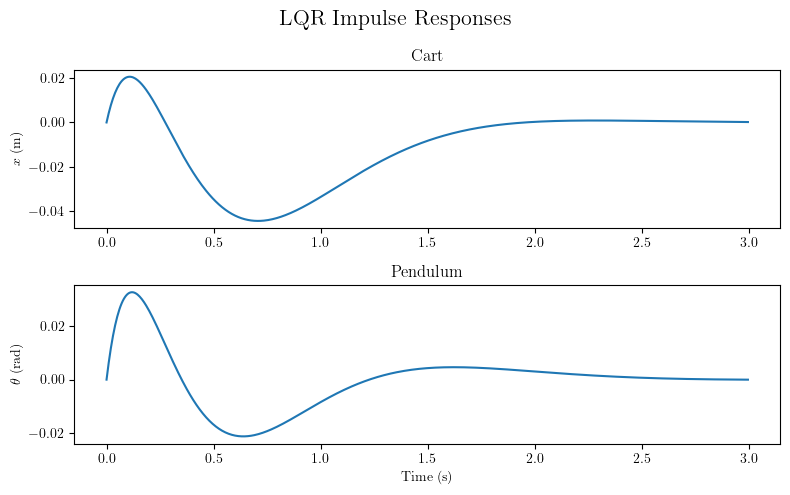

In [26]:
LQR_plots(T, sys, 1000, 100, 1, ['cart', 'pendulum'])

Not only are the built in functions in the **control** package much faster than using **mpmath**'s numerical inverse Laplace transform, but optimal control has reduced the time it takes both the cart and pendulum to settle to $(x,\theta) = (0,0)$ by seconds compared to the heuristic PID controller.

____
# LQG AND IMPULSE RESPONSE
____

## DEFINITIONS

In order to get convenient results, we can use a combination of "by-hand" analysis and built in functions to handle the LQG problem.

**WARNING**: We are about to define all of the physical parameters as **sympy** symbols, which may cause errors when reevaluating previous functions. To go back in the notebook, you should clear these definitions.

In [27]:
I, b, l, m, M, g, u = symbols('I,b,l,m,M,g,u')
K1, K2, K3, K4, L11, L21, L31, L41, L12, L22, L32, L42 = symbols('K1,K2,K3,K4,L11,L21,L31,L41,L12,L22,L32,L42')

#This dictionary is to be used in the sympy subs() function
values = {m:1., M:2., I:0.08333, l:0.5, b:0.1, g:9.8, u:mu()}

In [28]:
def build_component_transfer_fns(params = values):
    '''
    This builds the matrix versions of the system transfer function and the LQG transfer function (not closed loop, just implementing
    the Kalman filter and optimal control). Calculations are done symbolically at first using sympy to avoid numerical/rounding error 
    during the matrix inversion process. Values for the physical parameters (m, M, l, b, I, g, mu) are substituted in at the end.
    '''
    
    AA = Matrix(
        [
                [0,1,0,0],
                [0, -b*(I + m*l**2)/u, ((m*l)**2)*g/u, 0],
                [0, 0, 0, 1],
                [0, -b*m*l/u, (m+M)*m*g*l/u, 0]
            ]
    )

    BB = Matrix(
        [
                [0],
                [(I+m*l**2)/u],
                [0],
                [m*l/u]
            ]
    )

    CC = Matrix(
        [
                [1,0,0,0],
                [0,0,1,0]
            ]
    )
    
    Kop = Matrix(
        [
            [K1, K2, K3, K4]
        ]
    )
    
    Lkal = Matrix(
        [
            [L11, L12],
            [L21, L22],
            [L31, L32],
            [L41,L42]
        ]
    )
    
    Gsymb = simplify((CC*((s*Matrix.eye(4)-AA)**-1)*BB))
    Glqg_smyb = simplify(Kop*((s*Matrix.eye(4) - AA + BB*Kop + Lkal*CC)**-1)*Lkal)
    
    lqg_coef_denom = simplify(1 + Gsymb[0,0].subs(params)*Glqg_smyb[0,0].subs(params) + Gsymb[1,0].subs(params)*Glqg_smyb[0,1].subs(params))
    
    return Gsymb, lqg_coef_denom

In [29]:
#The matrix inversion used in this function is the mostly costly part of the process, so it is called up front to get it out of the way
#in order to tune the LQG gains
Gsymb, lqg_coef_denom = build_component_transfer_fns()

In [30]:
def build_LQG_transfer_fn(q_params, R, sigma_w, sigma_v1, sigma_v2, params=values, system = sys, G=Gsymb, denom_coef = lqg_coef_denom):
    '''
    Inputs:
     q_params: values of the quadratic cost function matrix Q, which penalizes deviations of the state vector from the reference
     R: value of the quadratic cost function parameter R, which penalizes control effort
     sigma_w: standard deviation of the input noise
     sigma_v1: standard deviation of measurement noise affecting cart position
     sigma_v2: standard deviation of measurement noise affecting pendulum angle
     params: values of physical constants
     system: ct.ss object representing the dynamics of the cart-pendulum system
     G: matrix transfer function for system
     denom_coef: inverse determinant of the matrix $1 + G*G_{LQG}$
    '''
    
    #Cost function matrix
    Q = q_params
    
    #Measurement noise covariance matrix
    Rv = np.array(
        [
            [sigma_v1**2, 0],
            [0, sigma_v2**2]
        ]
    )
    
    #Optimal gain
    K, _, _ = ct.lqr(system, Q, R)
    
    #Optimal (Kalman-Bucy) filter gain
    L, _, _ = ct.lqe(system, sigma_w**2, Rv)
    
    #Dictionary to use in subs()
    gains = {K1:K[0,0], K2:K[0,1], K3:K[0,2], K4:K[0,3], L11:L[0,0], L12:L[0,1], L21:L[1,0], L22:L[1,1], L31:L[2,0], L32:L[2,1], 
             L41:L[3,0], L42:L[3,1]}
    
    Tlqg = simplify((denom_coef.subs(gains)**-1)*G.subs(params))
    Tlqg10_numer = sp.Poly(sp.collect(sp.expand(sp.numer(Tlqg[1,0])),s),s).all_coeffs()
    Tlqg10_denom = sp.Poly(sp.collect(sp.expand(sp.denom(Tlqg[1,0])),s),s).all_coeffs()
    
    numer_coeffs = list(np.array(Tlqg10_numer, dtype=np.float64))
    denom_coeffs = list(np.array(Tlqg10_denom, dtype=np.float64))
    
    #The control package has a built in function to creat an LTI system by providing its transfer function, which allows us to use
    #the built in functions for impulse response
    return ct.tf(numer_coeffs, denom_coeffs), K, L

In [31]:
def build_costFunction_params(x_max = 0.05, xDot_max = .5, beta = 5., alpha = 0.5, theta_max = 0.02, thetaDot_max = 0.01, u_max=1.):
    return np.array(
        [
            [(beta**2)/(x_max**2), beta/(x_max*xDot_max), 0, 0],
            [beta/(x_max*xDot_max), 1/(xDot_max**2), 0, 0],
            [0, 0, (alpha**2)/(theta_max**2), alpha/(theta_max*thetaDot_max)],
            [0, 0, alpha/(theta_max*thetaDot_max), 1/(thetaDot_max**2)]
        ]
    ), 1/(u_max**2)

In [32]:
Q_params, R = build_costFunction_params()

In [33]:
def LQG_plots(time, q_params, R, sigma_w, sigma_v1, sigma_v2,):
    LQG_sys, Kfinal, Lfinal = build_LQG_transfer_fn(q_params, R, sigma_w, sigma_v1, sigma_v2)
    
    fig_LQG1 = plt.figure(figsize=(8,5))
    axLQG1 = fig_LQG1.add_axes([0.1, 0.1, 0.8, 0.81])

    ct.time_response_plot(ct.impulse_response(LQG_sys, time), title='', ax=axLQG1)

    axLQG1.set_xlabel('Time (s)')
    axLQG1.set_ylabel('$\\theta$ (rad)')

    fig_LQG1.suptitle('LQG Impulse Response', fontsize=16)

    plt.tight_layout()
    
    return Kfinal, Lfinal

/var/folders/47/0qdtcsrj5x9b2rp4qlkvlt5w0000gn/T/ipykernel_6867/4096596487.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


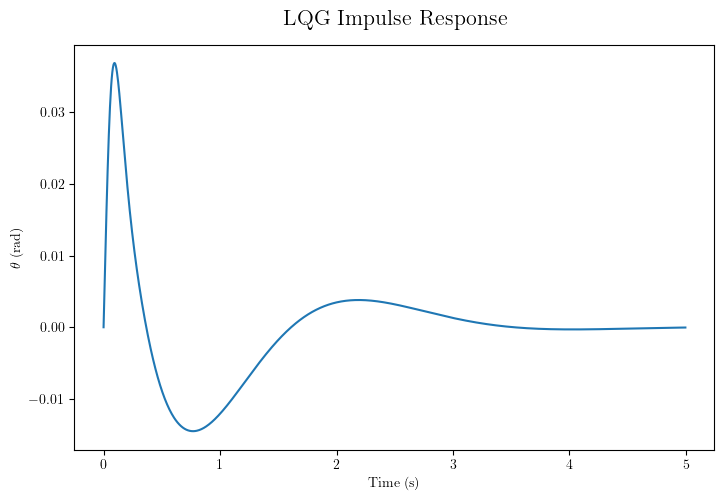

In [34]:
Kfin, Lfin = LQG_plots(T_extended, Q_params, R, 1., 0.001, 0.001)

In [35]:
Kfin

array([[-100.        , -105.0681678 ,  569.10100633,  177.25839897]])

In [36]:
Lfin

array([[ 15.81342966,  16.26874251],
       [257.36827021, 364.40296799],
       [ 16.26874251,  29.58368929],
       [374.15107085, 569.9333274 ]])